In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.stattools as st

import matplotlib
import matplotlib.pyplot as plt
#params = {'text.usetex' : True,'font.size' : 14}
#matplotlib.rcParams.update(params)

# Time Series Analysis

Based on the Penn State course, [STAT 510 Applied Time Series Analysis](https://online.stat.psu.edu/stat510/).

Models in which time $t$ value $x_t$ related to past values and past estimation errors are called ARIMA (Autoregressive Integrated Moving Average) models or Box-Jenkins models.

**Time Series** At each instant $t$, we have a random variable $x_t$.

**Weak Stationarity**
1. The mean is constant: $E(x_t)$ does not depend on $t$
2. The variance is constant: $\text{var}(x_t)$ does not depend on $t$
3. Time translation invariance of auto-covariances: $\text{cov}(x_t,x_{t-h})$ is independent of $t$ 

**White noise**

A set of uncorrelated random variables $w_t$ with zero mean and finite variance, is called white noise. In addition, if the variables are also independent of each other, we have iid white noise. If the distribution is normal, the series is called Gaussian white noise, and may be denoted as
$$
w_t \stackrel{iid}\sim N(0,\sigma_w^2)
$$

## Initial Analysis

Check for
* **Trend**
* **Seasonality**
* **Long-run cycle**
* **Outliers**
* **Constancy of variance**
* **Regime shifts**

## The autocorrelation function

  We designate the covariance of the random variables at two time instants, $t$ and $t-h$, as
  
  $$
  \gamma_x(t-h,t)=\text{cov}(x_{t-h},x_t)
  $$
  
  The lag $h$ **autocorrelation** $\rho_x(h)$ of a stationary series is given by
    $$
    \rho_x(h) = \frac{\gamma_x(t-h,t)}{\sqrt{\text{var}(x_{t-h})} \sqrt{\text{var}(x_{t})}}
    $$

## The partial autocorrelation function

In multiple regression, we use the partial correlation function to gauge the relationship between two variables while controlling for others. For example, if the dependent variable is $y$ and the regressors are $x_1,x_2$, and $x_3$, we can examine the relationship between $y$ and $x_3$ while controlling for $x_1$ and $x_2$. 

Let $\mathbf{e}_{y|x_1,x_2}$ and $\mathbf{e}_{x_3|x_1,x_2}$ be the residuals obtained by regressing $y$ and $x_3$ on $x_1,x_2$ respectively. Then the correlation between these two sets of residuals is the partial correlation between $y$ and $x_3$ while controlling for $x_1,x_2$. This is defined as:

$$
\rho_{y,x_3|x_1,x_2} = \frac{\text{cov}(y,x_3|x_1,x_2)}{\sqrt{\text{var}(y|x_1,x_2)}\sqrt{\text{var}(x_3|x_1,x_2)}}
$$

In time series analysis, we are interested in the partial autocorrelation function, which is the correlation between $x_t$ and $x_{t-h}$, while controlling for all random variables at intermediate instances, $x_{t-h+1},\cdots,x_{t-1}$.

Clearly, when $h=1$, there are no intermediate variables to control for, and the partial autocorrelation function is the same as the autocorrelation function with lag 1. For $h=2,3$, we have
$$
\rho_{x_t,x_{t-2}|x_{t-1}} = \frac{\text{cov}(x_t,x_{t-2}|x_{t-1})}{\sqrt{\text{var}(x_t|x_{t-1})}\sqrt{\text{var}(x_{t-2}|x_{t-1})}}
$$

$$
\rho_{x_t,x_{t-3}|x_{t-1},x_{t-2}} = \frac{\text{cov}(x_t,x_{t-3}|x_{t-1},x_{t-2})}{\sqrt{\text{var}(x_t|x_{t-1},x_{t-2})}\sqrt{\text{var}(x_{t-3}|x_{t-1},x_{t-2})}}
$$

## AR(1) model

\begin{equation}
\label{eq-AR1}
x_t = \delta + \phi_1 x_{t-1} + w_t
\end{equation}

where
$$
\begin{split}
w_t &\sim N(0,\sigma_w^2)\\
E(x_t,w_t) &= E(x_t)E(w_t) = 0
\end{split}
$$

**Properties of AR(1)**
1. $E(x_t) = \delta + \phi_1 E(x_{t-1}) \implies E(x_t) = \frac{\delta}{1-\phi_1}$
2. $\text{var}(x_t) = \phi_1^2 \text{var}(x_{t-1}) + \sigma_w^2 \implies \text{var}(x_t) = \frac{\sigma_w^2}{1-\phi_1^2} \implies |{\phi_1}| \lt 1$

3. Noting that the autocovariance is
    $$
    \begin{split}
    \gamma_x(t-1,t) &= \phi_1 \gamma_x(t-1,t-1) = \phi_1\text{var}(x_{t})\\
    \gamma_x(t-2,t) &= \phi_1 \gamma_x(t-2,t-1) = \phi_1^2\text{var}(x_{t})\\
    &\cdots \\
    \gamma_x(t-h,t) &= \phi_1^h \text{var}(x_t)
    \end{split}
$$

The autocorrelation $\rho_x(h)$ is given by
    $$
    \rho_x(h) = \frac{\gamma_x(t-h,t)}{\sqrt{\text{var}(x_{t-h})} \sqrt{\text{var}(x_{t})}} = \frac{\gamma_x(t-h,t)}{\text{var}(x_t)} = \phi_1^h
    $$

The last property gives us the autocorrelation function (**ACF**) of the model.

In [2]:
# 99 Years of data for worldwide magnitude 7+ earthquakes

foo = pd.read_csv("/home/vpoduri/Python-Stats/TSA_510_data/quakes.txt",header=None,sep="\s+")

# # Data wraps around. Concatenate to construct a series, drop NaN and reset the index

s1 = pd.concat([foo.iloc[r,:] for r in range(foo.shape[0])]).dropna().reset_index(drop=True).rename('quakes')

s1.describe()

count    99.000000
mean     20.020202
std       7.263242
min       6.000000
25%      15.000000
50%      20.000000
75%      24.000000
max      41.000000
Name: quakes, dtype: float64

## MA(1) model

\begin{equation}
\label{eq-MA1}
x_t = \mu + w_t + \theta_1w_{t-1} \quad w_t \stackrel{iid}\sim N(0,\sigma_w^2)
\end{equation}

**Properties of MA(1) model**
1. $E(x_t) = \mu$
2. $\text{var}(x_t) = \sigma_w^2 + \theta_1\sigma_w^2 = (1+\theta_1^2)\sigma_w^2$
3. $ \gamma_x(t-1,t) = \theta_1 \text{cov}(x_{t-1},w_{t-1}) = \theta_1 \sigma_w^2\;, \qquad \gamma_x(t-2,t)= 0$
 
    $\implies \rho_x(1) = \frac{\theta_1}{1+\theta_1^2}\;, \qquad \rho_x(h) = 0\; \text{for} \; h \ge 2$



## Relationship between AR and MA models

**MA(1) is an infinite AR model**

Define $z_t = x_t-\mu$ in (\ref{eq-MA1}). Then 
$$
\begin{split}
z_t &= w_t + \theta_1 w_{t-1}\\
&= w_t + \theta_1(z_{t-1}-\theta_1 w_{t-2}) = w_t +\theta_1z_{t-1} -\theta_1^2 w_{t-2}\\
&= w_t + \theta_1z_{t-1} -\theta_1^2(z_{t-2}-\theta_1 w_{t-3}) = w_t + \theta_1z_{t-1} -\theta_1^2 z_{t-2} + \theta_1^3 w_{t-3}
\end{split}
$$ 
Continuing this iterative process, we get
$$
z_t = w_t +\sum_{i=1}^\infty (-1)^{i+1} \theta_1^i z_{t-i}
$$

In order for the sum to converge, we need $|\theta_1| \lt 1$.

**AR(1) is an infinite MA model**

Starting with equation (\ref{eq-AR1}), we have
$$
\begin{split}
x_t &= \delta + \phi_1 x_{t-1} + w_t = \delta + \phi_1 (\delta + \phi_1 x_{t-2} + w_{t-1}) + w_t\\
&= w_t + \delta(1+\phi_1) + \phi_1^2 x_{t-2} +\phi_1 w_{t-1} \\
&= w_t + \delta(1+\phi_1+\phi_1^2) + \phi_1 w_{t-1} + \phi_1^2 w_{t-2} + \phi_1^3 x_{t-3}
\end{split}
$$

Continuing this way, we have
$$
\begin{split}
x_t &= \delta(1+\phi_1+\phi_1^2 + \cdots) + \sum_{i=0}^\infty \phi_1^i w_{t-i}\\
&= \delta \frac{1}{1-\phi_1} + \sum_{i=0}^\infty \phi_1^i w_{t-i}\\
&= \mu + \sum_{i=0}^\infty \phi_1^i w_{t-i}
\end{split}
$$
where the infinite geometric series with powers of $\phi_1$ converges because $|\phi_1| \lt 1$.



## Detecting the type of dependence

* For an AR($p$) model, the PACF is zero beyond lag $p$. Thus, the PACF is useful for identifying the order of and AR model.

* For an MA($q$) model, the ACF is non-zero only at lags involved in the model.

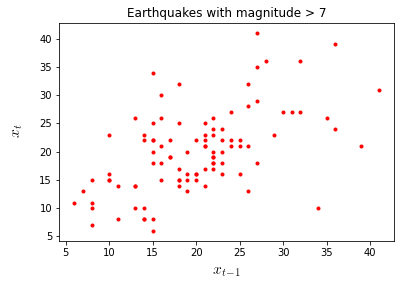

In [8]:
# Scatter plot

s1_lag = s1.shift()
plt.close()
fig,ax = plt.subplots(1,1)
ax.set_title("Earthquakes with magnitude > 7",usetex=False)
ax.set_xlabel(r"$x_{t-1}$",usetex=True,fontsize=16)
ax.set_ylabel(r"$x_t$", usetex=True,fontsize=16,labelpad=18)
_ = ax.plot(s1_lag.values,s1.values,'.r') 

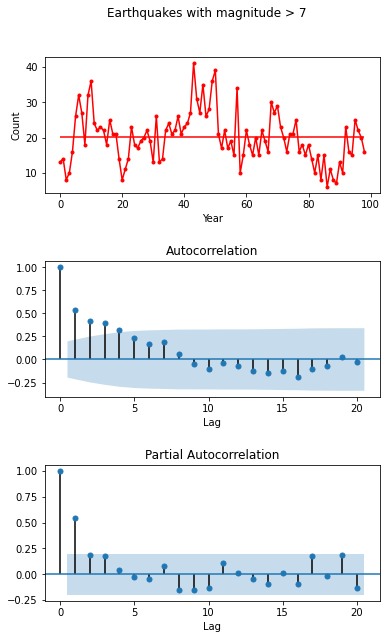

In [26]:
# Autocorrelation and partial autocorrelation functions

acf = st.acf(s1,nlags=10,fft=False)    # This calculated acf array can be plotted with  ax.plot(acf)

plt.close()
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(6,10))
plt.subplots_adjust(hspace=0.5)
_ = fig.suptitle('Earthquakes with magnitude > 7',usetex=False,y=0.95)   

_ = ax1.plot(s1.index,s1.values,'.-r') 
_ = ax1.hlines(s1.mean(),s1.index.min(),s1.index.max(),'r')   # add a line at the mean value
_ = ax1.set(xlabel='Year',ylabel='Count')


_= ax2.set_xlabel("Lag")
_ = sm.graphics.tsa.plot_acf(s1,ax=ax2,alpha=0.05)   # statsmodels function with 95% bands

_= ax3.set_xlabel("Lag")
_ = sm.graphics.tsa.plot_pacf(s1,ax=ax3,alpha=0.05)   # statsmodels function with 95% bands
